This is the results of the training done:

name | epochs | loss | val_loss | description
---|---|---|---|---|
coco_heads | 86 | 0.71 | 0.80 | start with **coco** + `head` up to 30 epochs then `all` up to the end. 
coco_all |  40 | 0.74 | 0.78 | start with **coco** + use `all` layers.
imagenet_all |  50 | 0.80 | 0.84 | start with **imagenet** + use `all` layers
coco_all_512x512 |  58 | 0.27 | 0.31 | **coco** weights + 512x512 images + train on all.
coco_512_new |  78 | 0.29 | 0.30 | **coco** weights + 512x512 images + train on all + hyper-parameters tweak.

In [ ]:
%matplotlib inline

from pathlib import Path

from sklearn.model_selection import train_test_split
import numpy as np

from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import visualize

import sys
sys.path.append("..")
import mask_lib as mlib

root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")

data_dir = root_dir / "data_small"
data_dir.mkdir(parents=True, exist_ok=True)

model_dir = root_dir / "logs"
model_dir.mkdir(parents=True, exist_ok=True)

coco_model_path = root_dir / "mask_rcnn_coco.h5"
if not coco_model_path.is_file():
    utils.download_trained_weights(str(coco_model_path))

# Load Training Dataset

In [113]:
# Split dataset
fnames = list(data_dir.glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, train_size=0.7)

# Build dataset
dataset_train = mlib.MicrotubuleDataset()
dataset_train.load_microtubules(train_fnames, verbose=True)

dataset_val = mlib.MicrotubuleDataset()
dataset_val.load_microtubules(validation_fnames, verbose=True)

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
                  

train_fnames : 0 | validation_fnames : 0


{'id': 448, 'source': 'microtubule', 'path': PosixPath('/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/data/image_snr_1.7_n-mts_16_id_2.tif'), 'width': 512, 'height': 512, 'line_thickness': 4}


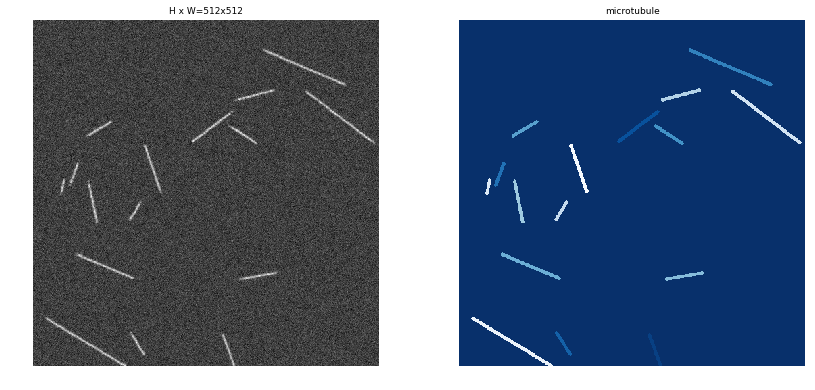

{'id': 14, 'source': 'microtubule', 'path': PosixPath('/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/data/image_snr_2.3_n-mts_21_id_0.tif'), 'width': 512, 'height': 512, 'line_thickness': 4}


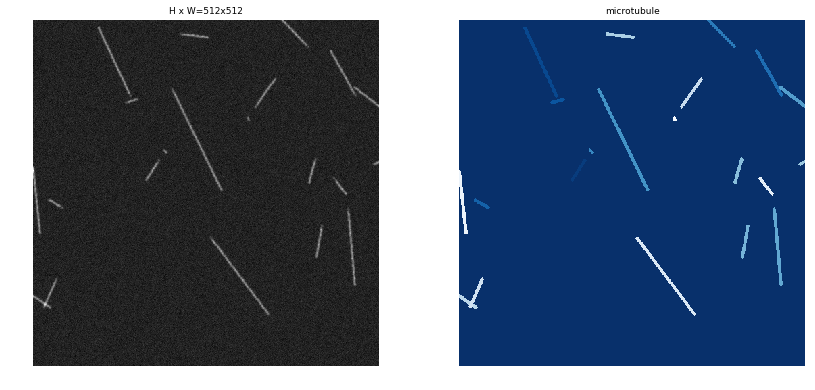

In [8]:
dataset_train.random_display(n=2)

# Configuration

In [4]:
config = mlib.MicrotubuleConfig()
config.set_images_per_gpu(8)

config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['BG', 'microtubule']
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  10
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           microtubule
NUM_CLASSES                    2
POOL_SIZE        

In [8]:
model = mlib.load_model(model_dir, config, mode="training")

init_with = "coco"  # imagenet, coco, or last
mlib.load_weights(model, init_with=init_with, coco_model_path=coco_model_path)

In [ ]:
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=200, layers='heads')

In [ ]:
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=200, layers='all')

# Detection

In [114]:
model_name = "microtubule_coco_512"
#model_name = None

config = mlib.MicrotubuleInferenceConfig()
config.set_images_per_gpu(1)

model = mlib.load_model(model_dir, config, mode="inference")
mlib.load_weights(model, init_with="last", model_name=model_name)

In [115]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 19

print(dataset_val.image_info[image_id])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, 
                                                                                   image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

ValueError: a must be non-empty

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.22000  max:  215.44000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


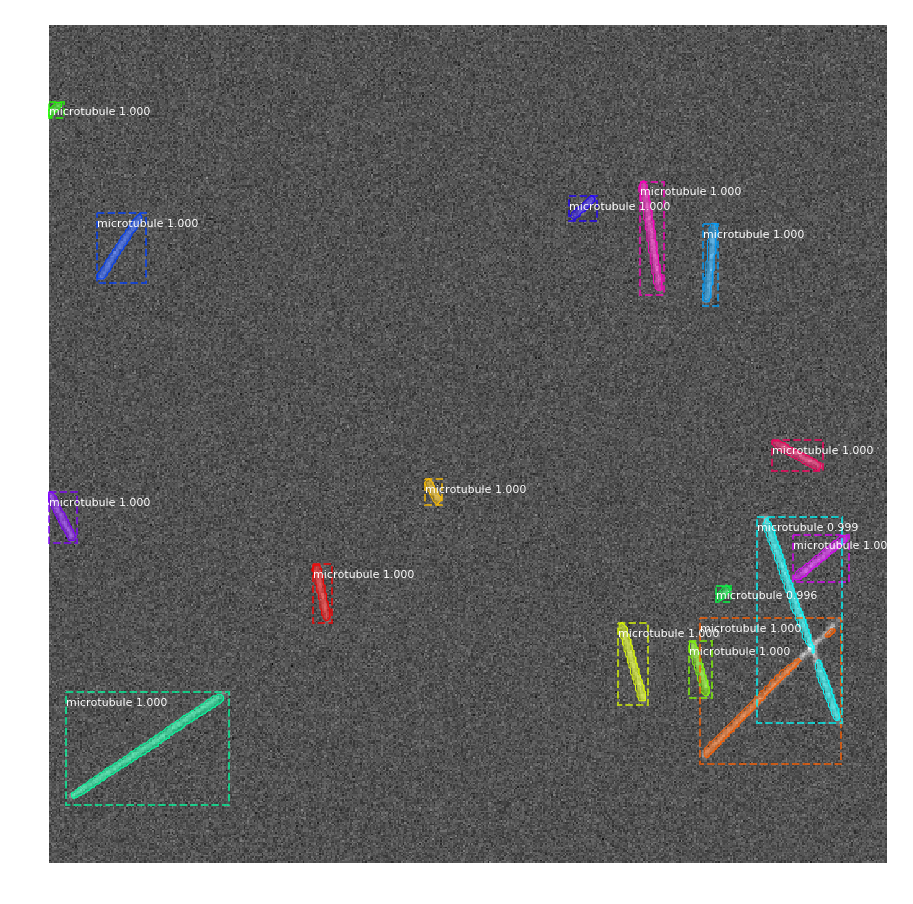

In [33]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

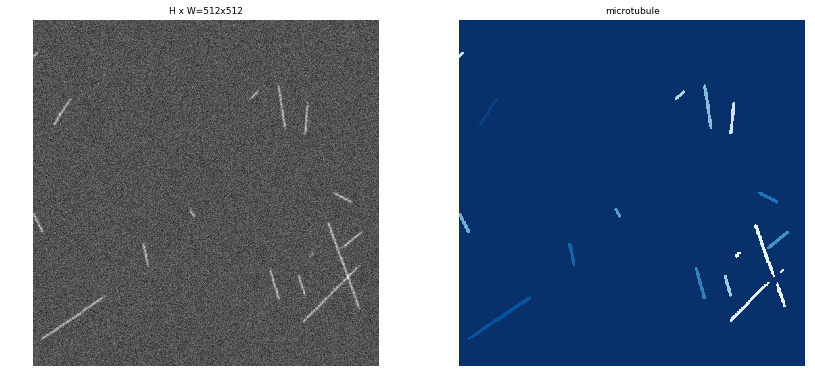

In [34]:
visualize.display_top_masks(original_image, r['masks'], r['class_ids'], dataset_train.class_names, limit=1)

# Explore Existing Models Training Summaries

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

logs_path = {}
for model_path in model_dir.iterdir():
    if model_path.is_dir():
        log_path = list(model_path.glob("*.out.tfevents.*"))[0]
        logs_path[model_path.name] = log_path

In [73]:
events = {}

for model_name, log_path in logs_path.items():
    for summary in tf.train.summary_iterator(str(log_path)):
        if summary.HasField("summary"):
            datum = {}
            datum["model_name"] = model_name
            datum["step"] = summary.step
            datum["wall_time"] = summary.wall_time
            datum[summary.summary.value[0].tag] = summary.summary.value[0].simple_value

            key_name = f"{model_name}_{summary.step}"
            if key_name not in events.keys():
                events[key_name] = {}

            events[key_name].update(datum)
        
events = pd.DataFrame.from_dict(events).T
events = events.sort_values(["model_name", "step"])
events.reset_index(inplace=True, drop=True)

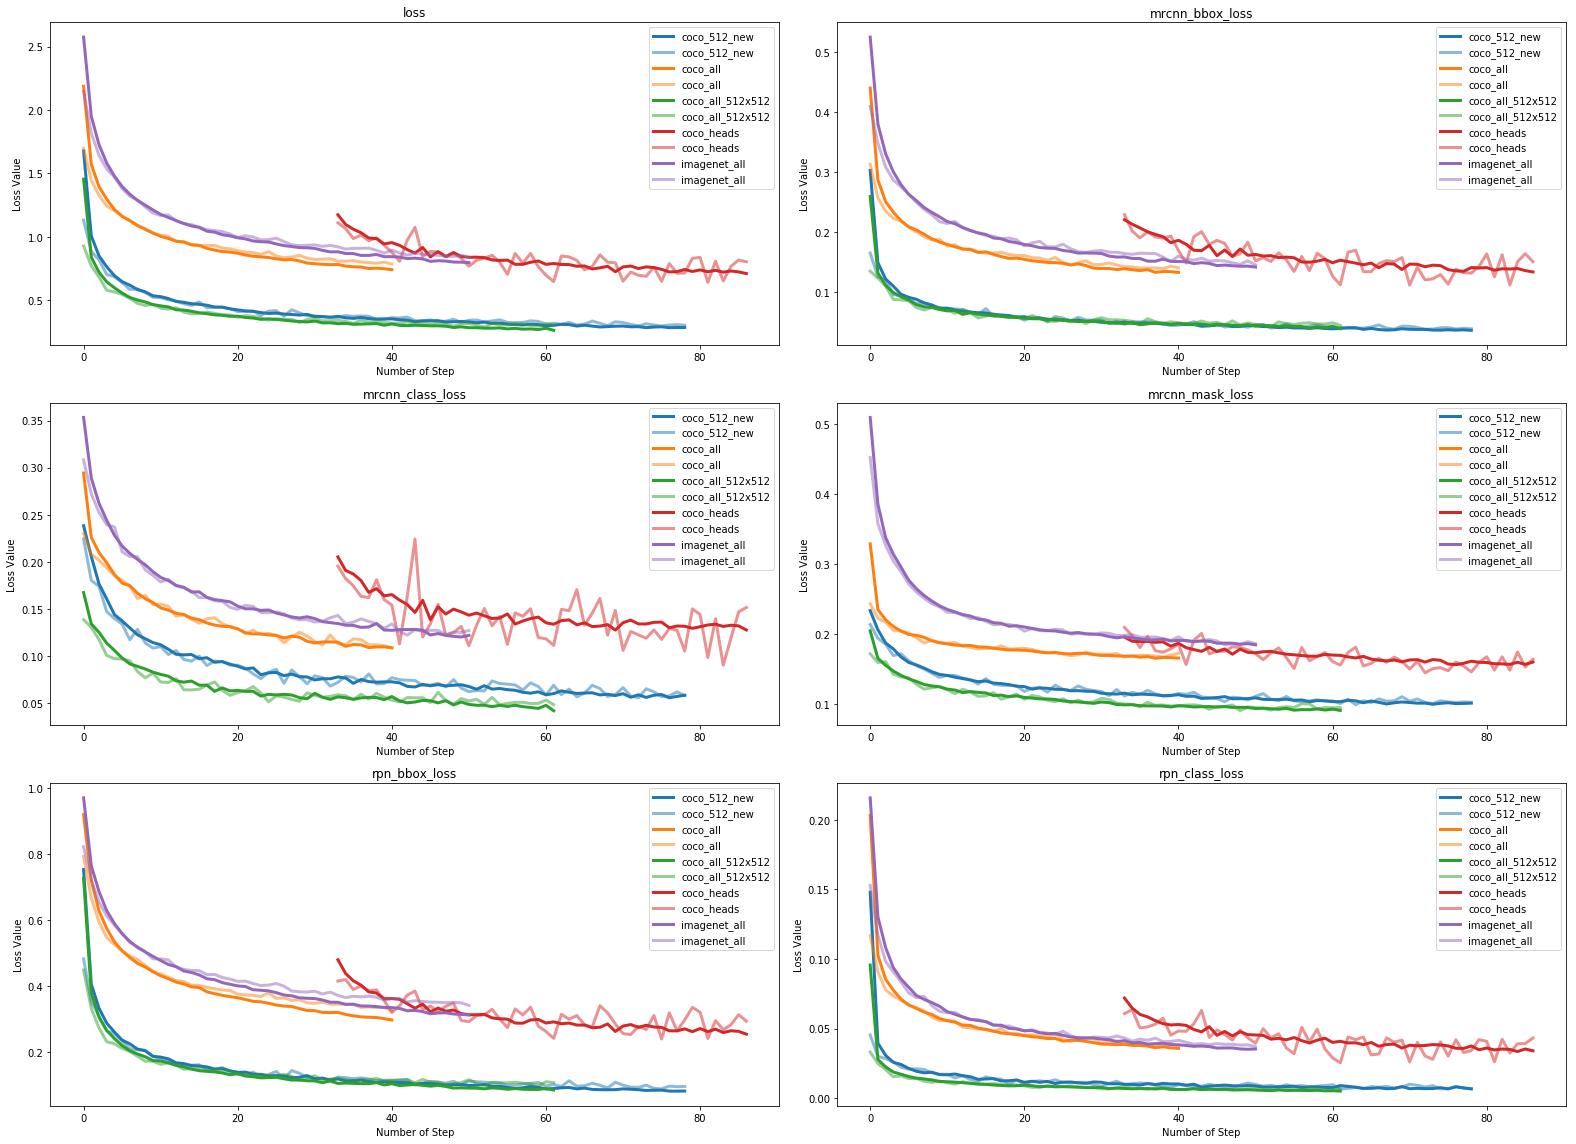

In [111]:
nrows = len(features) // 2
nrows += 1 if len(features) % 2 > 0 else 0
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(22, 16))

for ax, feature in zip(axs.flat, features):
    for i, row in events.groupby("model_name"):
        line = ax.plot(row.step, row[f"{feature}"], lw=3, label=i)[0]
        ax.plot(row.step, row[f"val_{feature}"], lw=3, color=line.get_color(), alpha=0.5, label=i)
        ax.set_title(feature)
        ax.set_xlabel("Number of Step")
        ax.set_ylabel("Loss Value")

    ax.legend()
    #ax.set_xscale("log")
    
fig.tight_layout()
fig.savefig(model_dir / "loss_values.png", dpi=200)